# Data loader and visulization

Testing data loader...

✓ Visualization saved to data_check_visualization.png

✓ All checks passed! Data loader is working correctly.


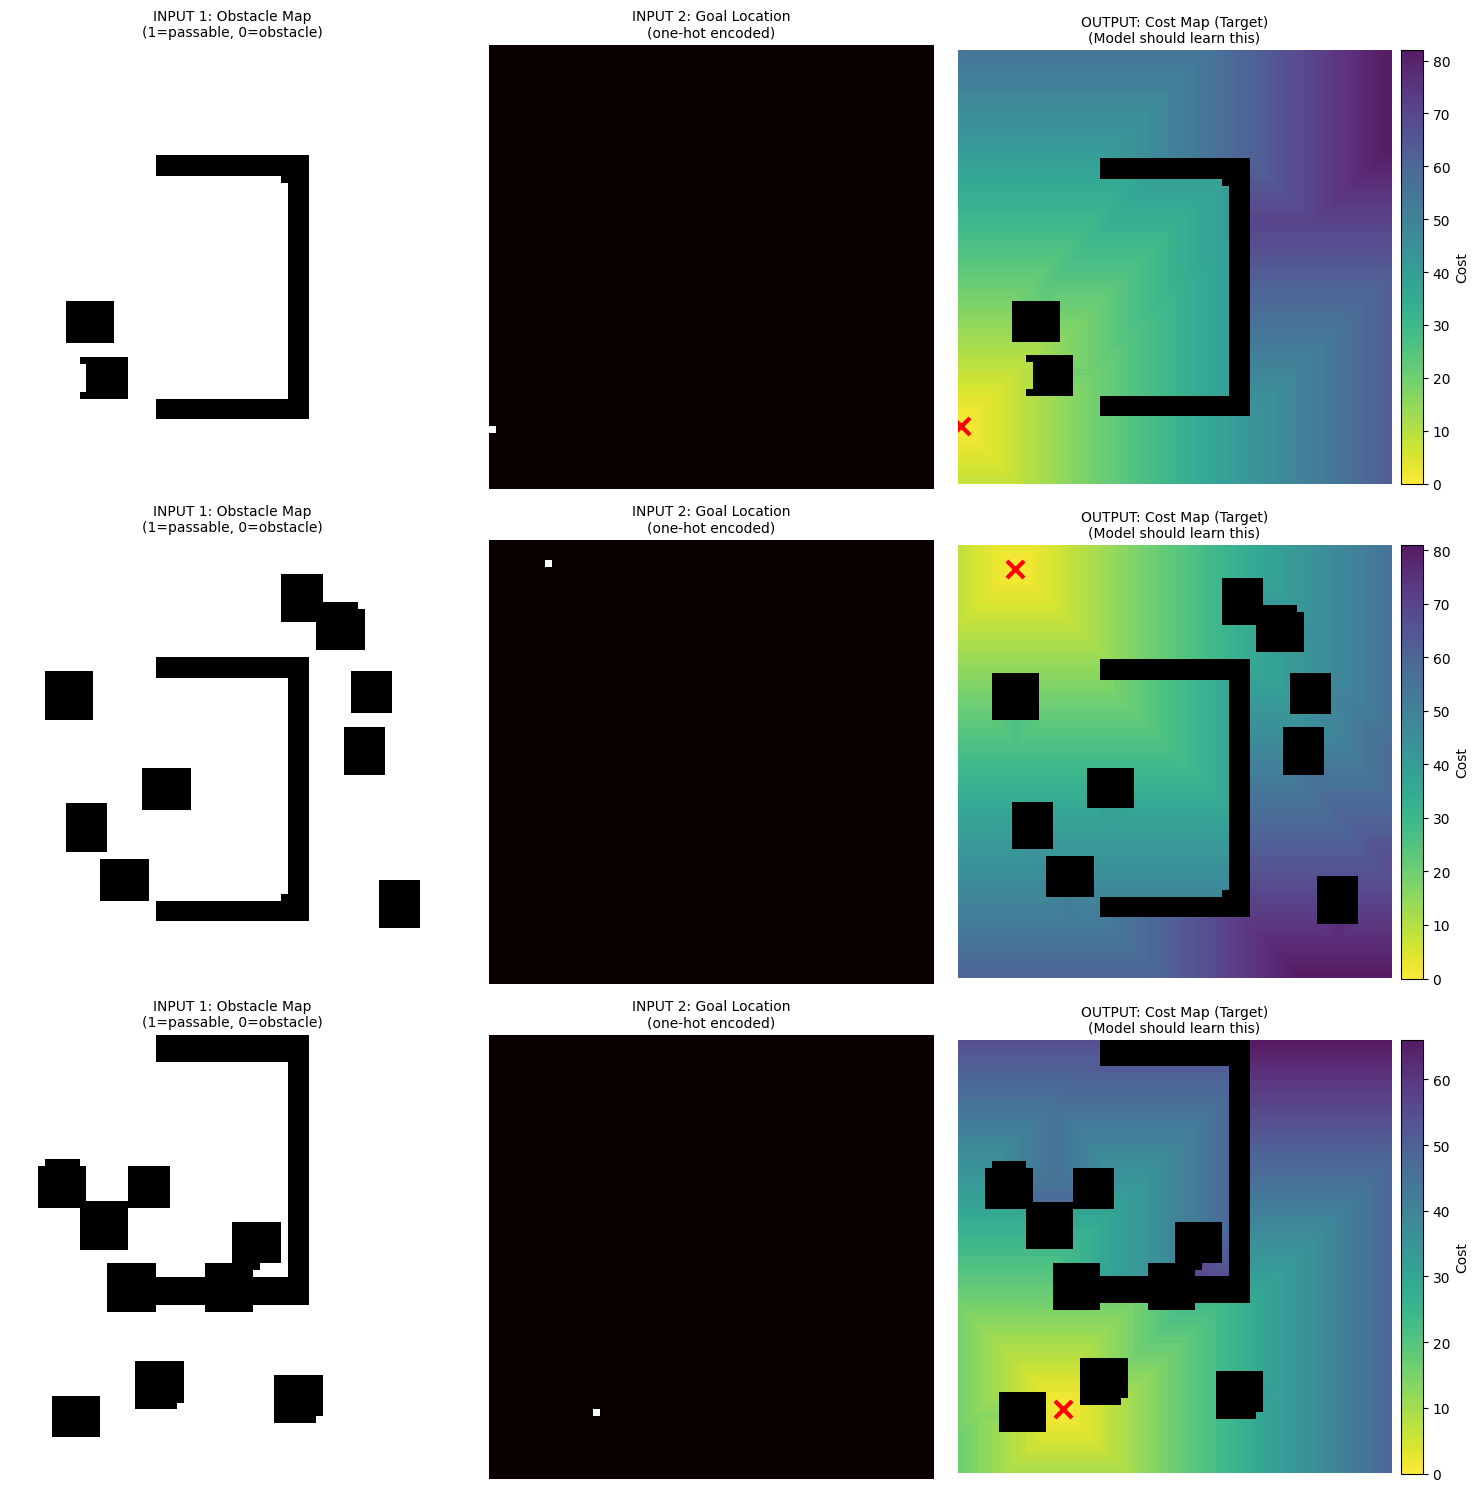

In [ ]:
"""
Dataset Loader for Modified A* Path Planning
Loads maze environments with ground truth optimal distances for supervised learning
"""

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

class PathPlanningDataset(Dataset):
    """
    Dataset for path planning with optimal distance supervision.

    Loads NPZ files containing:
    - map_designs: Obstacle maps (1 = passable, 0 = obstacle)
    - goal_maps: One-hot encoded goal locations
    - opt_dists: Optimal distances from each cell to goal

    Output format for training encoder:
    - obstacle_map: [1, 64, 64] - Binary obstacle map
    - goal_map: [1, 64, 64] - One-hot goal location
    - optimal_distances: [1, 64, 64] - Ground truth costs (supervision signal)
    """

    def __init__(self, npz_path: str, split: str = 'train'):
        """
        Initialize dataset from NPZ file.

        Args:
            npz_path: Path to .npz file containing dataset
            split: One of 'train', 'valid', or 'test'
        """
        assert npz_path.endswith('.npz'), "File must be in NPZ format"
        assert split in ['train', 'valid', 'test'], f"Invalid split: {split}"

        self.split = split
        self.npz_path = npz_path
        self.map_designs = None
        self.goal_maps = None
        self.opt_policies = None
        self.opt_dists = None
        self.VERBOSE = False
        # Load data from NPZ file
        self._load_data()

        if self.VERBOSE:
            print(f"\n{'='*60}")
            print(f"Loaded {split.upper()} dataset from: {npz_path}")
            print(f"Number of samples: {len(self)}")
            print(f"Map size: {self.map_designs.shape[1]}x{self.map_designs.shape[2]}")
            print(f"{'='*60}\n")

    def _load_data(self):
        """Load arrays from NPZ file based on split."""


        with np.load(self.npz_path) as data:
            # NPZ structure: arr_0, arr_1, arr_2, arr_3 for train
            #                arr_4, arr_5, arr_6, arr_7 for valid
            #                arr_8, arr_9, arr_10, arr_11 for test
            split_to_idx = {'train': 0, 'valid': 4, 'test': 8}
            base_idx = split_to_idx[self.split]

            # Load the four arrays for this split
            self.map_designs = data[f'arr_{base_idx}'].astype(np.float32)
            self.goal_maps = data[f'arr_{base_idx + 1}'].astype(np.float32)
            self.opt_policies = data[f'arr_{base_idx + 2}'].astype(np.float32)
            self.opt_dists = data[f'arr_{base_idx + 3}'].astype(np.float32)

            if self.VERBOSE:
                print(f"map_designs shape: {self.map_designs.shape}")
                print(f"goal_maps shape: {self.goal_maps.shape}")
                print(f"opt_dists shape: {self.opt_dists.shape}")

        # Verify shapes are consistent
        assert self.map_designs.shape[0] == self.goal_maps.shape[0]
        assert self.map_designs.shape[0] == self.opt_dists.shape[0]
        #assert self.map_designs.shape[1:] == self.opt_dists.shape[1:]

    def __len__(self):
        """Return number of samples in dataset."""
        return self.map_designs.shape[0]

    def __getitem__(self, idx: int):
      """
      Get a single training sample.

      Args:
          idx: Index of sample to retrieve

      Returns:
          obstacle_map: [1, H, W] - Binary map (1=passable, 0=obstacle)
          goal_map: [1, H, W] - One-hot encoded goal location
          optimal_distances: [1, H, W] - Ground truth distances for supervision
      """
      # map_designs is [H, W], needs channel dimension
      obstacle_map = self.map_designs[idx][np.newaxis, ...]

      # goal_maps and opt_dists already have channel dimension [1, H, W]
      goal_map = self.goal_maps[idx]
      optimal_distances = self.opt_dists[idx]

      # Convert negative distances to positive (dataset encoding)
      optimal_distances = np.abs(optimal_distances)

      return obstacle_map, goal_map, optimal_distances

    def get_statistics(self):
      """Compute dataset statistics for analysis."""
      # Use absolute values for distances
      abs_dists = np.abs(self.opt_dists)
      valid_dists = abs_dists[abs_dists > 0]

      stats = {
          'num_samples': len(self),
          'map_size': self.map_designs.shape[1:],
          'avg_obstacle_ratio': float(1 - self.map_designs.mean()),
          'avg_optimal_distance': float(valid_dists.mean()) if len(valid_dists) > 0 else 0.0,
          'max_optimal_distance': float(abs_dists.max()),
      }
      return stats


def create_dataloader(npz_path: str,
                      split: str,
                      batch_size: int,
                      shuffle: bool = True,
                      num_workers: int = 0):
    """
    Create PyTorch DataLoader for path planning dataset.

    Args:
        npz_path: Path to NPZ dataset file
        split: 'train', 'valid', or 'test'
        batch_size: Number of samples per batch
        shuffle: Whether to shuffle data (typically True for train)
        num_workers: Number of parallel data loading workers

    Returns:
        DataLoader yielding batches of (obstacle_maps, goal_maps, optimal_distances)
    """
    dataset = PathPlanningDataset(npz_path, split)

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()  # Speed up GPU transfer
    )


def check_data_loading(npz_path: str, split: str = 'train', num_samples: int = 3, VERBOSE: bool = False):
    """
    Verify data loading works correctly and visualize samples.
    Shows: Obstacles (input), Goal (input), Cost Map (target output)

    Args:
        npz_path: Path to NPZ dataset file
        split: Which split to check
        num_samples: Number of samples to display
    """
    import matplotlib.pyplot as plt

    if VERBOSE:
        print(f"\n{'='*60}")
        print(f"DATA LOADING CHECK")
        print(f"{'='*60}\n")

    # Create dataset
    dataset = PathPlanningDataset(npz_path, split)

    # Print statistics
    if VERBOSE:
        stats = dataset.get_statistics()
        print("Dataset Statistics:")
        for key, value in stats.items():
            print(f"  {key}: {value}")

    # Create dataloader
    dataloader = create_dataloader(npz_path, split, batch_size=4, shuffle=False)

    # Get one batch
    obstacle_maps, goal_maps, opt_dists = next(iter(dataloader))

    if VERBOSE:
        print(f"\nBatch Shapes:")
        print(f"  Obstacle maps: {obstacle_maps.shape}")
        print(f"  Goal maps: {goal_maps.shape}")
        print(f"  Optimal distances: {opt_dists.shape}")

        print(f"\nValue Ranges:")
        print(f"  Obstacles: [{obstacle_maps.min():.2f}, {obstacle_maps.max():.2f}]")
        print(f"  Goals: [{goal_maps.min():.2f}, {goal_maps.max():.2f}]")
        print(f"  Distances: [{opt_dists.min():.2f}, {opt_dists.max():.2f}]")

    # ========== VISUALIZATION ==========
    # Create figure with 3 columns: Obstacles, Goal, Cost Heatmap
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(num_samples, len(obstacle_maps))):
        # Convert to numpy and remove channel dimension
        obstacle_map = obstacle_maps[i, 0].numpy()
        goal_map = goal_maps[i, 0].numpy()
        opt_dist = opt_dists[i, 0].numpy()

        # --- Column 1: Obstacle Map (INPUT) ---
        axes[i, 0].imshow(obstacle_map, cmap='gray')
        axes[i, 0].set_title('INPUT 1: Obstacle Map\n(1=passable, 0=obstacle)', fontsize=10)
        axes[i, 0].axis('off')

        # --- Column 2: Goal Map (INPUT) ---
        axes[i, 1].imshow(goal_map, cmap='hot')
        axes[i, 1].set_title('INPUT 2: Goal Location\n(one-hot encoded)', fontsize=10)
        axes[i, 1].axis('off')

        # --- Column 3: Cost Heatmap (TARGET OUTPUT) - IMPROVED ---
        # Find goal coordinates
        goal_coords = np.where(goal_map == 1)
        if len(goal_coords[0]) > 0:
            goal_y, goal_x = goal_coords[0][0], goal_coords[1][0]
        else:
            goal_y, goal_x = None, None

        # Create masked array (obstacles = NaN)
        viz_dist = np.copy(opt_dist)
        obstacle_mask = (obstacle_map == 0)
        viz_dist[obstacle_mask] = np.nan

        # Layer 1: Draw obstacles in black
        axes[i, 2].imshow(obstacle_map == 0, cmap='gray_r', vmin=0, vmax=1)

        # Layer 2: Overlay cost gradient
        im = axes[i, 2].imshow(viz_dist, cmap='viridis_r', alpha=0.9, interpolation='nearest')

        # Mark goal with red 'X'
        if goal_x is not None and goal_y is not None:
            axes[i, 2].scatter(goal_x, goal_y, marker='x', c='red', s=150,
                              linewidths=3, zorder=10)

        axes[i, 2].set_title('OUTPUT: Cost Map (Target)\n(Model should learn this)', fontsize=10)
        axes[i, 2].axis('off')

        # Add proper colorbar (doesn't shrink plot)
        divider = make_axes_locatable(axes[i, 2])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(im, cax=cax, label="Cost")

    plt.tight_layout()
    plt.savefig('data_check_visualization.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Visualization saved to data_check_visualization.png")
    if VERBOSE:
        print(f"\n{'='*60}")
        print(f"DATA LOADING CHECK COMPLETE ✓")
        print(f"{'='*60}\n")

    return dataset, dataloader


if __name__ == "__main__":
    # Example usage
    print("Testing data loader...")

    # dataset location
    npz_path = "bugtrap_forest_064_moore_c16.npz"

    try:
        dataset, dataloader = check_data_loading(npz_path, split='train', num_samples=3)
        print("\n✓ All checks passed! Data loader is working correctly.")
    except FileNotFoundError:
        print(f"\n✗ File not found: {npz_path}")
        print("Please update the npz_path to your actual dataset location.")
    except Exception as e:
        print(f"\n✗ Error during data loading: {e}")
        raise

# Encoder CNN


TESTING UNTRAINED HeuristicCNN

Model parameters: 31,908,901
Device: cuda

Running forward pass...
Input obstacle_maps shape: torch.Size([4, 1, 64, 64])
Input goal_maps shape: torch.Size([4, 1, 64, 64])
Output distance_maps shape: torch.Size([4, 1, 64, 64])
Output value range: [0.09, 0.10]

✓ Visualization saved to: visualization/untrained_model_test.png

TEST COMPLETE ✓



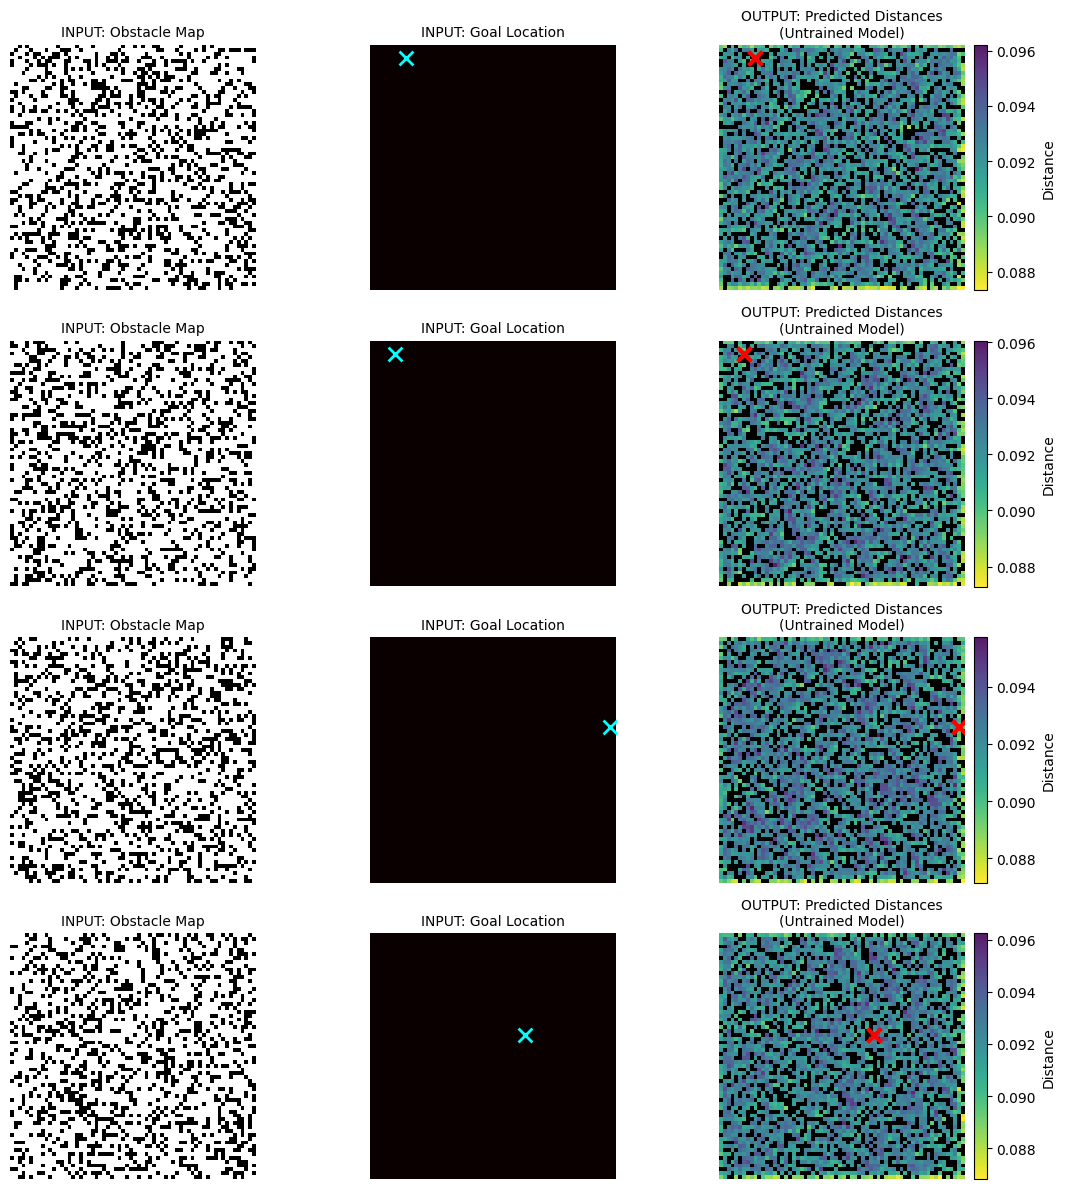

In [ ]:
"""
Learned Heuristic Encoder for A* Pathfinding
=============================================
Neural network that predicts distance-to-goal heuristics from obstacle and goal maps.

Input: obstacle_map [B, 1, H, W] + goal_map [B, 1, H, W]
Output: distance_map [B, 1, H, W] - predicted distance from each cell to goal
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

#from dataset import PathPlanningDataset


class AttentionGate(nn.Module):
    """
    Attention Gate to filter encoder features before skip connection.

    Args:
        F_g: Number of channels in gating signal (from decoder)
        F_l: Number of channels in skip connection (from encoder)
        F_int: Number of intermediate channels (typically F_l // 2)
    """
    def __init__(self, F_g, F_l, F_int):
        super().__init__()

        # Transform gating signal to intermediate dimension
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )

        # Transform skip connection to intermediate dimension
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )

        # Output 1-channel attention map
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        Args:
            g: Gating signal from decoder (upsampled features)
            x: Skip connection from encoder

        Returns:
            x_att: Attention-filtered skip connection
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi  # Element-wise multiplication

class DoubleConv(nn.Module):
    """Two consecutive conv layers with BatchNorm and ReLU"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    """Downsampling block: MaxPool + DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.downsample = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.downsample(x)


class Up(nn.Module):
    """Upsampling block with Attention Gate: Upsample + Attention + Concatenate + DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Attention gate
        # in_channels = F_g + F_l (concatenated), so F_g = out_channels, F_l = out_channels
        decoder_channels = in_channels - out_channels  # Decoder features
        encoder_channels = out_channels                # Encoder skip connection

        self.attention = AttentionGate(
            F_g=decoder_channels,      # Gating signal from decoder
            F_l=encoder_channels,      # Skip connection from encoder
            F_int=encoder_channels // 2
        )

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_decoder, x_encoder):
        """
        x_decoder: upsampled features from decoder (gating signal)
        x_encoder: skip connection from encoder
        """
        x_decoder = self.up(x_decoder)

        # Handle size mismatch (keep existing padding logic)
        diffY = x_encoder.size()[2] - x_decoder.size()[2]
        diffX = x_encoder.size()[3] - x_decoder.size()[3]
        x_decoder = F.pad(x_decoder, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Apply attention gate to skip connection
        x_encoder = self.attention(g=x_decoder, x=x_encoder)

        # Concatenate attention-filtered skip connection
        x = torch.cat([x_encoder, x_decoder], dim=1)
        return self.conv(x)


class HeuristicCNN(nn.Module):
    """
    UNet-based CNN for learning distance-to-goal heuristics.

    Architecture:
    - Encoder: 4 downsampling blocks (64 → 128 → 256 → 512)
    - Bottleneck: 1024 channels
    - Decoder: 4 upsampling blocks with skip connections
    - Output: 1-channel distance map

    Args:
        in_channels: Number of input channels (default: 2 for obstacle + goal maps)
        base_channels: Base number of channels (default: 64)
    """

    def __init__(self, in_channels=2, base_channels=64):
        super().__init__()

        # Encoder (downsampling path)
        self.inc = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)

        # Bottleneck
        self.down4 = Down(base_channels * 8, base_channels * 16)

        # Decoder (upsampling path)
        self.up1 = Up(base_channels * 16 + base_channels * 8, base_channels * 8)
        self.up2 = Up(base_channels * 8 + base_channels * 4, base_channels * 4)
        self.up3 = Up(base_channels * 4 + base_channels * 2, base_channels * 2)
        self.up4 = Up(base_channels * 2 + base_channels, base_channels)

        # Output layer
        self.outc = nn.Sequential(
            nn.Conv2d(base_channels, 1, kernel_size=1),
            nn.ReLU()  # Distances must be non-negative
        )

    def forward(self, obstacle_map, goal_map):
        """
        Forward pass through the network.

        Args:
            obstacle_map: [B, 1, H, W] - Binary obstacle map (1=passable, 0=obstacle)
            goal_map: [B, 1, H, W] - One-hot encoded goal location

        Returns:
            distance_map: [B, 1, H, W] - Preadicted distances to goal
        """
        # Concatenate inputs
        x = torch.cat([obstacle_map, goal_map], dim=1)  # [B, 2, H, W]

        # Encoder
        x1 = self.inc(x)      # [B, 64, H, W]
        x2 = self.down1(x1)   # [B, 128, H/2, W/2]
        x3 = self.down2(x2)   # [B, 256, H/4, W/4]
        x4 = self.down3(x3)   # [B, 512, H/8, W/8]

        # Bottleneck
        x5 = self.down4(x4)   # [B, 1024, H/16, W/16]

        # Decoder with skip connections
        x = self.up1(x5, x4) # [B, 512, H/8, W/8]
        x = self.up2(x, x3)   # [B, 256, H/4, W/4]
        x = self.up3(x, x2)   # [B, 128, H/2, W/2]
        x = self.up4(x, x1)   # [B, 64, H, W]

        # Output
        distance_map = self.outc(x)  # [B, 1, H, W]

        return distance_map


# ============================================================================
# VISUALIZATION TEST
# ============================================================================

def test_untrained_model():
    """
    Test that the untrained model can generate cost maps.
    Visualizes input (obstacle + goal) and predicted output.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    print("\n" + "="*60)
    print("TESTING UNTRAINED HeuristicCNN")
    print("="*60 + "\n")

    # Create model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HeuristicCNN(in_channels=2, base_channels=64).to(device)
    model.eval()

    # Count parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {num_params:,}")
    print(f"Device: {device}\n")

    # Create synthetic test data (64x64 map)
    batch_size = 4
    H, W = 64, 64

    # Random obstacle maps
    obstacle_maps = torch.rand(batch_size, 1, H, W) > 0.3  # 30% obstacles
    obstacle_maps = obstacle_maps.float().to(device)

    # Random goal locations
    goal_maps = torch.zeros(batch_size, 1, H, W).to(device)
    for i in range(batch_size):
        goal_y, goal_x = np.random.randint(H), np.random.randint(W)
        goal_maps[i, 0, goal_y, goal_x] = 1.0

    # Run inference
    print("Running forward pass...")
    with torch.no_grad():
        predicted_distances = model(obstacle_maps, goal_maps)

    print(f"Input obstacle_maps shape: {obstacle_maps.shape}")
    print(f"Input goal_maps shape: {goal_maps.shape}")
    print(f"Output distance_maps shape: {predicted_distances.shape}")
    print(f"Output value range: [{predicted_distances.min():.2f}, {predicted_distances.max():.2f}]")

    # ========== VISUALIZATION ==========
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 3*batch_size))
    if batch_size == 1:
        axes = axes.reshape(1, -1)

    for i in range(batch_size):
        obstacle_map = obstacle_maps[i, 0].cpu().numpy()
        goal_map = goal_maps[i, 0].cpu().numpy()
        pred_dist = predicted_distances[i, 0].cpu().numpy()

        # Find goal coordinates
        goal_coords = np.where(goal_map == 1)
        goal_y, goal_x = (goal_coords[0][0], goal_coords[1][0]) if len(goal_coords[0]) > 0 else (None, None)

        # Column 1: Obstacle Map
        axes[i, 0].imshow(obstacle_map, cmap='gray')
        axes[i, 0].set_title('INPUT: Obstacle Map', fontsize=10)
        axes[i, 0].axis('off')

        # Column 2: Goal Map
        axes[i, 1].imshow(goal_map, cmap='hot')
        if goal_x is not None:
            axes[i, 1].scatter(goal_x, goal_y, marker='x', c='cyan', s=100, linewidths=2)
        axes[i, 1].set_title('INPUT: Goal Location', fontsize=10)
        axes[i, 1].axis('off')

        # Column 3: Predicted Distance Map
        # Mask obstacles
        viz_dist = np.copy(pred_dist)
        viz_dist[obstacle_map == 0] = np.nan

        # Plot obstacles as black background
        axes[i, 2].imshow(obstacle_map == 0, cmap='gray_r', vmin=0, vmax=1)

        # Overlay predicted distances
        im = axes[i, 2].imshow(viz_dist, cmap='viridis_r', alpha=0.9, interpolation='nearest')

        # Mark goal
        if goal_x is not None:
            axes[i, 2].scatter(goal_x, goal_y, marker='x', c='red', s=100, linewidths=3, zorder=10)

        axes[i, 2].set_title('OUTPUT: Predicted Distances\n(Untrained Model)', fontsize=10)
        axes[i, 2].axis('off')

        # Add colorbar
        divider = make_axes_locatable(axes[i, 2])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(im, cax=cax, label="Distance")

    plt.tight_layout()
    plt.savefig('untrained_model_test.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Visualization saved to: visualization/untrained_model_test.png")

    print("\n" + "="*60)
    print("TEST COMPLETE ✓")
    print("="*60 + "\n")

    return model


if __name__ == "__main__":
    # Run visualization test
    model = test_untrained_model()

    #print("\nModel architecture summary:")
    #print(model)

# Train_Heuristic

In [ ]:
"""
Training Pipeline for Learned A* Heuristics with Admissibility Enforcement
===========================================================================
Trains HeuristicCNN to predict distance-to-goal maps from obstacle and goal configurations.
Enhanced with admissibility-aware loss to ensure predictions don't overestimate distances.

Usage:
    python train_heuristic.py --data_path <path_to_npz> --epochs 100 --batch_size 16
"""

import os
import argparse
import time
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

#from dataset import PathPlanningDataset, create_dataloader
#from learned_heuristic_encoder import HeuristicCNNV

class AdmissibleDistanceLoss(nn.Module):
    """
    Loss function that enforces admissibility by heavily penalizing overestimation.

    Admissibility means the heuristic never overestimates the true cost to goal.
    This is critical for A* optimality: overestimation can cause suboptimal paths,
    while underestimation only reduces efficiency but maintains optimality.

    Args:
        overestimation_penalty: Weight for penalizing inadmissible predictions (default: 10.0)
        loss_type: Base loss function ('mse' or 'l1')
        boundary_penalty: Extra weight for underestimation on cells next to walls (default: 5.0)
    """

    def __init__(self, overestimation_penalty=10.0, loss_type='mse', boundary_penalty=5.0):
        super().__init__()
        self.overestimation_penalty = overestimation_penalty
        self.boundary_penalty = boundary_penalty
        self.loss_type = loss_type

    def forward(self, pred_distances, target_distances, obstacle_map):
        """
        Args:
            pred_distances: [B, 1, H, W] - Predicted distance map
            target_distances: [B, 1, H, W] - Ground truth distance map
            obstacle_map: [B, 1, H, W] - Binary map (1=passable, 0=obstacle)

        Returns:
            total_loss: Weighted combination of overestimation and underestimation
            over_loss: Overestimation component (for monitoring)
            under_loss: Underestimation component (for monitoring)
        """
        # Create mask for passable cells only
        mask = (obstacle_map > 0).float()

        # Compute raw errors (positive = overestimate, negative = underestimate)
        errors = pred_distances - target_distances

        # Separate overestimation (inadmissible) from underestimation (safe)
        overestimations = torch.relu(errors)    # Only positive errors
        underestimations = torch.relu(-errors)  # Only negative errors

        # Apply base loss function
        if self.loss_type == 'mse':
            over_element_loss = overestimations ** 2
            under_element_loss = underestimations ** 2
        elif self.loss_type == 'l1':
            over_element_loss = overestimations
            under_element_loss = underestimations
        else:
            raise ValueError(f"Unknown loss type: {self.loss_type}")

        # --- Boundary-Aware Loss Logic ---
        # 1. Create wall map (1=wall, 0=passable)
        wall_map = 1.0 - obstacle_map

        # 2. Define kernel to find HORIZONTAL (Left/Right) neighbors
        kernel_weights = torch.tensor([[0, 0, 0],
                                       [1, 0, 1],
                                       [0, 0, 0]], dtype=torch.float32, device=pred_distances.device).view(1, 1, 3, 3)

        # 3. Find cells adjacent to horizontal walls
        adjacent_to_horiz_wall = F.conv2d(wall_map, kernel_weights, padding=1)

        # 4. Boundary mask = Passable cells AND adjacent to a horizontal wall
        boundary_mask = (adjacent_to_horiz_wall > 0).float() * mask

        # 5. Create a weight map for underestimation.
        # Weight = 1.0 for non-boundary, Weight = self.boundary_penalty for boundary.
        non_boundary_mask = mask - boundary_mask
        under_weight_map = non_boundary_mask + (boundary_mask * self.boundary_penalty)
        # --- End Boundary Logic ---

        # Apply mask and compute mean over valid cells
        over_loss = (over_element_loss * mask).sum() / (mask.sum() + 1e-8)

        # Apply weighted underestimation loss
        weighted_under_element_loss = under_element_loss * under_weight_map
        total_under_loss = weighted_under_element_loss.sum() / (under_weight_map.sum() + 1e-8)

        # For logging, return the unweighted average underestimation (same as before)
        under_loss_metric = (under_element_loss * mask).sum() / (mask.sum() + 1e-8)

        # Heavily penalize overestimation to encourage admissibility
        total_loss = self.overestimation_penalty * over_loss + total_under_loss

        return total_loss, over_loss, under_loss_metric


class HeuristicTrainer:
    """
    Trainer class for HeuristicCNN model with admissibility enforcement.

    Handles training loop, validation, checkpointing, and comprehensive
    admissibility metric logging.
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 device='cuda',
                 learning_rate=1e-3,
                 weight_decay=1e-4,
                 overestimation_penalty=10.0,
                 loss_type='mse',
                 boundary_penalty=5.0, # Added
                 checkpoint_dir='./models'):
        """
        Initialize trainer.

        Args:
            model: HeuristicCNN model
            train_loader: Training data loader
            val_loader: Validation data loader
            device: Device to train on ('cuda' or 'cpu')
            learning_rate: Initial learning rate
            weight_decay: Weight decay for optimizer
            overestimation_penalty: Penalty weight for inadmissible predictions (default: 10.0)
            loss_type: Loss function type ('mse' or 'l1')
            boundary_penalty: Extra penalty for underestimation near walls (default: 5.0)
            checkpoint_dir: Directory to save model checkpoints
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.checkpoint_dir = checkpoint_dir

        # Loss and optimizer (now using admissibility-aware loss)
        self.criterion = AdmissibleDistanceLoss(
            overestimation_penalty=overestimation_penalty,
            loss_type=loss_type,
            boundary_penalty=boundary_penalty # Added
        )
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
        #testing new scheduler
        ''' self.scheduler = optim.lr_scheduler.MultiStepLR(
            self.optimizer,
            milestones=[25, 50, 75],  # Reduce at these epochs
            gamma=0.5
        ) '''

        # Tracking
        self.best_val_loss = float('inf')
        self.train_losses = []
        self.val_losses = []
        self.current_epoch = 0

        # New: Admissibility tracking
        self.train_over_losses = []
        self.train_under_losses = []
        self.val_over_losses = []
        self.val_under_losses = []
        self.val_inadmissible_ratios = []
        self.val_avg_overestimations = []
        self.val_max_overestimations = []

        # Create checkpoint directory
        os.makedirs(checkpoint_dir, exist_ok=True)

        print(f"\n{'='*70}")
        print(f"Trainer Initialized with Admissibility Enforcement")
        print(f"{'='*70}")
        print(f"Device: {device}")
        print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"Optimizer: AdamW (lr={learning_rate}, weight_decay={weight_decay})")
        print(f"Loss: {loss_type.upper()} with overestimation penalty = {overestimation_penalty}x")
        print(f"Boundary Underestimation Penalty: {boundary_penalty}x") # Added
        print(f"Train batches: {len(train_loader)}")
        print(f"Val batches: {len(val_loader)}")
        print(f"{'='*70}\n")

    def train_epoch(self):
        """Run one training epoch with admissibility tracking."""
        self.model.train()
        epoch_loss = 0.0
        epoch_over_loss = 0.0
        epoch_under_loss = 0.0
        batch_count = 0

        for batch_idx, (obstacle_maps, goal_maps, target_distances) in enumerate(self.train_loader):
            # Move to device
            obstacle_maps = obstacle_maps.to(self.device)
            goal_maps = goal_maps.to(self.device)
            target_distances = target_distances.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            pred_distances = self.model(obstacle_maps, goal_maps)

            # Compute loss (returns 3 values now)
            loss, over_loss, under_loss = self.criterion(
                pred_distances, target_distances, obstacle_maps
            )

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Track metrics
            epoch_loss += loss.item()
            epoch_over_loss += over_loss.item()
            epoch_under_loss += under_loss.item()
            batch_count += 1

            # Print progress every 10 batches
            if (batch_idx + 1) % 10 == 0:
                avg_loss = epoch_loss / batch_count
                avg_over = epoch_over_loss / batch_count
                avg_under = epoch_under_loss / batch_count
                print(f"   Batch [{batch_idx+1}/{len(self.train_loader)}] - "
                      f"Loss: {loss.item():.6f} (Avg: {avg_loss:.6f}) | "
                      f"Over: {avg_over:.6f} | Under: {avg_under:.6f}")

        avg_epoch_loss = epoch_loss / batch_count
        avg_over_loss = epoch_over_loss / batch_count
        avg_under_loss = epoch_under_loss / batch_count

        self.train_losses.append(avg_epoch_loss)
        self.train_over_losses.append(avg_over_loss)
        self.train_under_losses.append(avg_under_loss)

        return avg_epoch_loss

    def validate(self):
        """Run validation with comprehensive admissibility analysis."""
        self.model.eval()
        val_loss = 0.0
        val_over_loss = 0.0
        val_under_loss = 0.0
        batch_count = 0

        # Admissibility tracking
        total_cells = 0
        inadmissible_cells = 0
        total_overestimation = 0.0
        max_overestimation = 0.0

        # Standard metrics
        total_mae = 0.0
        total_max_error = 0.0

        with torch.no_grad():
            for obstacle_maps, goal_maps, target_distances in self.val_loader:
                # Move to device
                obstacle_maps = obstacle_maps.to(self.device)
                goal_maps = goal_maps.to(self.device)
                target_distances = target_distances.to(self.device)

                # Forward pass
                pred_distances = self.model(obstacle_maps, goal_maps)

                # Compute loss
                loss, over_loss, under_loss = self.criterion(
                    pred_distances, target_distances, obstacle_maps
                )
                val_loss += loss.item()
                val_over_loss += over_loss.item()
                val_under_loss += under_loss.item()

                # Compute additional metrics (masked)
                mask = (obstacle_maps > 0).float()
                errors = torch.abs(pred_distances - target_distances) * mask
                total_mae += (errors.sum() / (mask.sum() + 1e-8)).item()
                total_max_error += errors.max().item()

                # Admissibility analysis
                overestimations = torch.relu(pred_distances - target_distances) * mask
                num_passable = mask.sum().item()
                num_inadmissible = (overestimations > 0).sum().item()

                total_cells += num_passable
                inadmissible_cells += num_inadmissible
                total_overestimation += overestimations.sum().item()
                max_overestimation = max(max_overestimation, overestimations.max().item())

                batch_count += 1

        avg_val_loss = val_loss / batch_count
        avg_over_loss = val_over_loss / batch_count
        avg_under_loss = val_under_loss / batch_count
        avg_mae = total_mae / batch_count
        avg_max_error = total_max_error / batch_count

        # Admissibility metrics
        inadmissible_ratio = inadmissible_cells / (total_cells + 1e-8)
        avg_overestimation = total_overestimation / (total_cells + 1e-8)

        self.val_losses.append(avg_val_loss)
        self.val_over_losses.append(avg_over_loss)
        self.val_under_losses.append(avg_under_loss)
        self.val_inadmissible_ratios.append(inadmissible_ratio)
        self.val_avg_overestimations.append(avg_overestimation)
        self.val_max_overestimations.append(max_overestimation)

        return (avg_val_loss, avg_over_loss, avg_under_loss,
                avg_mae, avg_max_error,
                inadmissible_ratio, avg_overestimation, max_overestimation)

    def save_checkpoint(self, filename='checkpoint.pth', is_best=False):
        """Save model checkpoint with admissibility metrics."""
        checkpoint = {
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_val_loss': self.best_val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_over_losses': self.train_over_losses,
            'train_under_losses': self.train_under_losses,
            'val_over_losses': self.val_over_losses,
            'val_under_losses': self.val_under_losses,
            'val_inadmissible_ratios': self.val_inadmissible_ratios,
            'val_avg_overestimations': self.val_avg_overestimations,
            'val_max_overestimations': self.val_max_overestimations,
        }

        checkpoint_path = os.path.join(self.checkpoint_dir, filename)
        torch.save(checkpoint, checkpoint_path)

        if is_best:
            best_path = os.path.join(self.checkpoint_dir, 'best_heuristic_model.pth')
            torch.save(checkpoint, best_path)
            print(f"   ✓ New best model saved: {best_path}")

    def load_checkpoint(self, filename='checkpoint.pth'):
        """Load model checkpoint."""
        checkpoint_path = os.path.join(self.checkpoint_dir, filename)
        if not os.path.exists(checkpoint_path):
            print(f"   ✗ Checkpoint not found: {checkpoint_path}")
            return False

        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.current_epoch = checkpoint['epoch']
        self.best_val_loss = checkpoint['best_val_loss']
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']

        # Load admissibility metrics if available
        if 'train_over_losses' in checkpoint:
            self.train_over_losses = checkpoint['train_over_losses']
            self.train_under_losses = checkpoint['train_under_losses']
            self.val_over_losses = checkpoint['val_over_losses']
            self.val_under_losses = checkpoint['val_under_losses']
            self.val_inadmissible_ratios = checkpoint['val_inadmissible_ratios']
            self.val_avg_overestimations = checkpoint['val_avg_overestimations']
            self.val_max_overestimations = checkpoint['val_max_overestimations']

        print(f"   ✓ Checkpoint loaded: {checkpoint_path} (Epoch {self.current_epoch})")
        return True

    def train(self, num_epochs, save_every=10, visualize_every=20):
        """
        Main training loop with admissibility monitoring.

        Args:
            num_epochs: Number of epochs to train
            save_every: Save checkpoint every N epochs
            visualize_every: Create visualization every N epochs
        """
        print(f"\n{'='*70}")
        print(f"Starting Training with Admissibility Enforcement")
        print(f"Overestimation Penalty: {self.criterion.overestimation_penalty}x")
        print(f"Boundary Underestimation Penalty: {self.criterion.boundary_penalty}x") # Added
        print(f"{'='*70}\n")

        start_time = time.time()

        for epoch in range(self.current_epoch, num_epochs):
            self.current_epoch = epoch
            epoch_start_time = time.time()

            # Training
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            train_loss = self.train_epoch()

            # Validation
            (val_loss, val_over_loss, val_under_loss,
             val_mae, val_max_error,
             inadmissible_ratio, avg_overest, max_overest) = self.validate()

            # Learning rate scheduling
            self.scheduler.step(val_loss)
            #self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            # Timing
            epoch_time = time.time() - epoch_start_time

            # Print epoch summary with admissibility info
            print(f"\n   Epoch Summary:")
            print(f"     Train Loss: {train_loss:.6f}")
            print(f"     Val Loss:   {val_loss:.6f}")
            print(f"       ├─ Overestimation Loss:  {val_over_loss:.6f}")
            print(f"       └─ Underestimation Loss: {val_under_loss:.6f}")
            print(f"     Val MAE:    {val_mae:.4f}")
            print(f"     Val Max Err: {val_max_error:.4f}")
            print(f"     📊 ADMISSIBILITY METRICS:")
            print(f"       ├─ Inadmissible Cells: {inadmissible_ratio*100:.2f}% (Target: <1%)")
            print(f"       ├─ Avg Overestimation: {avg_overest:.4f}")
            print(f"       └─ Max Overestimation: {max_overest:.4f}")
            print(f"     Learning Rate: {current_lr:.2e}")
            print(f"     Time: {epoch_time:.2f}s")

            # Save best model (consider both loss and admissibility)
            if val_loss < self.best_val_loss and inadmissible_ratio < 0.02:
                improvement = self.best_val_loss - val_loss
                self.best_val_loss = val_loss
                print(f"   ⭐ Best validation loss improved by {improvement:.6f} "
                      f"(Inadmissible: {inadmissible_ratio*100:.2f}%)")
                self.save_checkpoint(is_best=True)

            # Periodic checkpoint
            if (epoch + 1) % save_every == 0:
                self.save_checkpoint(filename=f'checkpoint_epoch_{epoch+1}.pth')

            # Periodic visualization
            if (epoch + 1) % visualize_every == 0:
                self.visualize_predictions(epoch+1)
                self.visualize_admissibility(epoch+1)

            print(f"{'─'*70}\n")

        # Training complete
        total_time = time.time() - start_time
        final_inadm = self.val_inadmissible_ratios[-1] if self.val_inadmissible_ratios else 0

        print(f"\n{'='*70}")
        print(f"Training Complete!")
        print(f"{'='*70}")
        print(f"Total time: {total_time/60:.2f} minutes")
        print(f"Best validation loss: {self.best_val_loss:.6f}")
        print(f"Final inadmissible ratio: {final_inadm*100:.2f}%")
        if final_inadm < 0.01:
            print(f"✓ Excellent! Model is highly admissible (<1% violations)")
        elif final_inadm < 0.05:
            print(f"✓ Good! Model is mostly admissible (<5% violations)")
        else:
            print(f"⚠ Warning: Model has {final_inadm*100:.1f}% inadmissible predictions")
            print(f"   Consider increasing overestimation_penalty or training longer")
        print(f"Final model saved to: {self.checkpoint_dir}")
        print(f"{'='*70}\n")

        # Plot training curves
        self.plot_training_curves()

    def visualize_predictions(self, epoch):
        """Visualize model predictions on validation set."""
        self.model.eval()

        # Get one batch from validation set
        obstacle_maps, goal_maps, target_distances = next(iter(self.val_loader))
        obstacle_maps = obstacle_maps.to(self.device)
        goal_maps = goal_maps.to(self.device)
        target_distances = target_distances.to(self.device)

        # Generate predictions
        with torch.no_grad():
            pred_distances = self.model(obstacle_maps, goal_maps)

        # Visualize first 4 samples
        num_samples = min(4, obstacle_maps.size(0))
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)

        for i in range(num_samples):
            obstacle_map = obstacle_maps[i, 0].cpu().numpy()
            target_dist = target_distances[i, 0].cpu().numpy()
            pred_dist = pred_distances[i, 0].cpu().numpy()

            # Mask obstacles
            obstacle_mask = (obstacle_map == 0)
            target_dist_masked = np.copy(target_dist)
            pred_dist_masked = np.copy(pred_dist)
            target_dist_masked[obstacle_mask] = np.nan
            pred_dist_masked[obstacle_mask] = np.nan

            # Plot obstacle map
            axes[i, 0].imshow(obstacle_map, cmap='gray')
            axes[i, 0].set_title('Obstacle Map', fontsize=10)
            axes[i, 0].axis('off')

            # Plot ground truth
            axes[i, 1].imshow(obstacle_map == 0, cmap='gray_r', vmin=0, vmax=1)
            im1 = axes[i, 1].imshow(target_dist_masked, cmap='viridis_r', alpha=0.9)
            axes[i, 1].set_title('Ground Truth Distances', fontsize=10)
            axes[i, 1].axis('off')
            plt.colorbar(im1, ax=axes[i, 1], fraction=0.046)

            # Plot predictions
            axes[i, 2].imshow(obstacle_map == 0, cmap='gray_r', vmin=0, vmax=1)
            im2 = axes[i, 2].imshow(pred_dist_masked, cmap='viridis_r', alpha=0.9)
            axes[i, 2].set_title('Predicted Distances', fontsize=10)
            axes[i, 2].axis('off')
            plt.colorbar(im2, ax=axes[i, 2], fraction=0.046)

        plt.tight_layout()
        viz_path = os.path.join(self.checkpoint_dir, f'predictions_epoch_{epoch}.png')
        plt.savefig(viz_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"   ✓ Prediction visualization saved: {viz_path}")

    def visualize_admissibility(self, epoch):
        """
        Visualize where the model overestimates (inadmissible regions).
        Red areas indicate cells where predicted distance > true distance.
        """
        self.model.eval()

        # Get one batch from validation set
        obstacle_maps, goal_maps, target_distances = next(iter(self.val_loader))
        obstacle_maps = obstacle_maps.to(self.device)
        goal_maps = goal_maps.to(self.device)
        target_distances = target_distances.to(self.device)

        # Generate predictions
        with torch.no_grad():
            pred_distances = self.model(obstacle_maps, goal_maps)

        # Visualize first 2 samples
        num_samples = min(2, obstacle_maps.size(0))
        fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)

        for i in range(num_samples):
            obstacle_map = obstacle_maps[i, 0].cpu().numpy()
            target_dist = target_distances[i, 0].cpu().numpy()
            pred_dist = pred_distances[i, 0].cpu().numpy()

            # Compute overestimation map
            errors = pred_dist - target_dist
            overestimations = np.maximum(0, errors)  # Only positive errors

            # Mask obstacles
            obstacle_mask = (obstacle_map == 0)
            target_dist_masked = np.copy(target_dist)
            pred_dist_masked = np.copy(pred_dist)
            overest_masked = np.copy(overestimations)

            target_dist_masked[obstacle_mask] = np.nan
            pred_dist_masked[obstacle_mask] = np.nan
            overest_masked[obstacle_mask] = np.nan

            # Plot 1: Obstacle map
            axes[i, 0].imshow(obstacle_map, cmap='gray')
            axes[i, 0].set_title('Obstacle Map', fontsize=10)
            axes[i, 0].axis('off')

            # Plot 2: Ground truth
            axes[i, 1].imshow(obstacle_map == 0, cmap='gray_r', vmin=0, vmax=1)
            im1 = axes[i, 1].imshow(target_dist_masked, cmap='viridis_r', alpha=0.9)
            axes[i, 1].set_title('Ground Truth', fontsize=10)
            axes[i, 1].axis('off')
            plt.colorbar(im1, ax=axes[i, 1], fraction=0.046)

            # Plot 3: Predictions
            axes[i, 2].imshow(obstacle_map == 0, cmap='gray_r', vmin=0, vmax=1)
            im2 = axes[i, 2].imshow(pred_dist_masked, cmap='viridis_r', alpha=0.9)
            axes[i, 2].set_title('Predicted', fontsize=10)
            axes[i, 2].axis('off')
            plt.colorbar(im2, ax=axes[i, 2], fraction=0.046)

            # Plot 4: Overestimation heatmap
            axes[i, 3].imshow(obstacle_map == 0, cmap='gray_r', vmin=0, vmax=1)
            im3 = axes[i, 3].imshow(overest_masked, cmap='Reds', alpha=0.9, vmin=0)

            # Count inadmissible cells
            inadm_count = (overestimations[~obstacle_mask] > 0).sum()
            total_count = (~obstacle_mask).sum()
            inadm_pct = 100 * inadm_count / total_count if total_count > 0 else 0

            title_color = 'green' if inadm_pct < 5 else ('orange' if inadm_pct < 10 else 'red')
            axes[i, 3].set_title(f'Overestimation Map\n{inadm_pct:.1f}% Inadmissible',
                                   fontsize=10, color=title_color, fontweight='bold')
            axes[i, 3].axis('off')
            plt.colorbar(im3, ax=axes[i, 3], fraction=0.046, label='Overestimation')

        plt.suptitle(f'Admissibility Analysis - Epoch {epoch}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        viz_path = os.path.join(self.checkpoint_dir, f'admissibility_epoch_{epoch}.png')
        plt.savefig(viz_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"   ✓ Admissibility visualization saved: {viz_path}")

    def plot_training_curves(self):
        """Plot and save comprehensive training curves with admissibility metrics."""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        epochs = range(1, len(self.train_losses) + 1)

        # Plot 1: Overall loss
        axes[0, 0].plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        axes[0, 0].plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)

        # Mark best validation
        if self.val_losses:
            best_epoch = np.argmin(self.val_losses) + 1
            axes[0, 0].axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5,
                               label=f'Best Val (Epoch {best_epoch})')

        axes[0, 0].set_xlabel('Epoch', fontsize=12)
        axes[0, 0].set_ylabel('Total Loss', fontsize=12)
        axes[0, 0].set_title('Training Progress', fontsize=14, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Loss components
        if self.train_over_losses and self.train_under_losses:
            axes[0, 1].plot(epochs, self.train_over_losses, 'r-',
                          label='Train Overestimation', linewidth=2, alpha=0.7)
            axes[0, 1].plot(epochs, self.train_under_losses, 'b-',
                          label='Train Underestimation', linewidth=2, alpha=0.7)
            axes[0, 1].plot(epochs, self.val_over_losses, 'r--',
                          label='Val Overestimation', linewidth=2)
            axes[0, 1].plot(epochs, self.val_under_losses, 'b--',
                          label='Val Underestimation', linewidth=2)
            axes[0, 1].set_xlabel('Epoch', fontsize=12)
            axes[0, 1].set_ylabel('Loss Component', fontsize=12)
            axes[0, 1].set_title('Loss Components', fontsize=14, fontweight='bold')
            axes[0, 1].legend(fontsize=9)
            axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Inadmissible ratio over time
        if self.val_inadmissible_ratios:
            axes[1, 0].plot(epochs, [r*100 for r in self.val_inadmissible_ratios],
                          'orange', linewidth=2, marker='o', markersize=3)
            axes[1, 0].axhline(y=1.0, color='g', linestyle='--', alpha=0.5,
                               label='1% Target (Excellent)', linewidth=2)
            axes[1, 0].axhline(y=5.0, color='orange', linestyle='--', alpha=0.5,
                               label='5% Threshold (Good)', linewidth=2)
            axes[1, 0].axhline(y=10.0, color='r', linestyle='--', alpha=0.5,
                               label='10% Limit', linewidth=2)
            axes[1, 0].set_xlabel('Epoch', fontsize=12)
            axes[1, 0].set_ylabel('Inadmissible Cells (%)', fontsize=12)
            axes[1, 0].set_title('Admissibility Violations', fontsize=14, fontweight='bold')
            axes[1, 0].legend(fontsize=9)
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].set_ylim(bottom=0)

        # Plot 4: Average overestimation
        if self.val_avg_overestimations:
            axes[1, 1].plot(epochs, self.val_avg_overestimations,
                          'purple', linewidth=2, marker='s', markersize=3)
            axes[1, 1].set_xlabel('Epoch', fontsize=12)
            axes[1, 1].set_ylabel('Average Overestimation', fontsize=12)
            axes[1, 1].set_title('Mean Overestimation on Val Set', fontsize=14, fontweight='bold')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].set_ylim(bottom=0)

        plt.tight_layout()
        curve_path = os.path.join(self.checkpoint_dir, 'training_curves.png')
        plt.savefig(curve_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"   ✓ Training curves saved: {curve_path}")


def train(npz_path,
          num_epochs=100,
          batch_size=16,
          learning_rate=1e-3,
          weight_decay=1e-4,
          overestimation_penalty=50.0,# Was 10.0
          loss_type='mse',
          boundary_penalty=5.0, # Added
          device='cuda',
          checkpoint_dir='./models',
          resume=None):
    """
    Main training function with admissibility enforcement.

    Args:
        npz_path: Path to NPZ dataset file
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Initial learning rate
        weight_decay: Weight decay for regularization
        overestimation_penalty: Penalty weight for inadmissible predictions (default: 10.0)
                                Higher values = stronger admissibility enforcement
        loss_type: Loss function type ('mse' or 'l1')
        boundary_penalty: Extra penalty for underestimation near walls (default: 5.0)
        device: Device to train on ('cuda' or 'cpu')
        checkpoint_dir: Directory to save checkpoints
        resume: Path to checkpoint to resume from (optional)
    """
    # Set device
    if device == 'cuda' and not torch.cuda.is_available():
        print("⚠ CUDA not available, falling back to CPU")
        device = 'cpu'

    # Create dataloaders
    print("Loading datasets...")
    train_loader = create_dataloader(npz_path, split='train', batch_size=batch_size, shuffle=True)
    val_loader = create_dataloader(npz_path, split='valid', batch_size=batch_size, shuffle=False)

    # Create model
    print("Initializing model...")
    model = HeuristicCNN(in_channels=2, base_channels=64)

    # Create trainer with admissibility enforcement
    trainer = HeuristicTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        overestimation_penalty=overestimation_penalty,
        loss_type=loss_type,
        boundary_penalty=boundary_penalty, # Added
        checkpoint_dir=checkpoint_dir
    )

    # Resume from checkpoint if specified
    if resume:
        trainer.load_checkpoint(resume)

    # Train
    trainer.train(num_epochs=num_epochs)

    return trainer


if __name__ == "__main__":

    # --- Define your training settings here ---
    DATA_PATH = "bugtrap_forest_064_moore_c16.npz"
    EPOCHS = 100
    BATCH_SIZE = 32
    LEARNING_RATE = 5e-4  # Was 1e-3
    WEIGHT_DECAY = 1e-4
    OVERESTIMATION_PENALTY = 50  #was 50
    BOUNDARY_PENALTY = 5.0 # Added - Start with 5.0 and tune
    LOSS_TYPE = 'l1'  # Was 'mse'
    DEVICE = 'cuda'              # 'cuda' or 'cpu'
    CHECKPOINT_DIR = './models'
    RESUME_CHECKPOINT = None      # e.g., './models/checkpoint.pth' or None
    # ------------------------------------------

    print("\n" + "="*70)
    print("TRAINING HEURISTIC CNN WITH ADMISSIBILITY ENFORCEMENT")
    print("="*70)
    print(f"Dataset: {DATA_PATH}")
    print(f"Overestimation Penalty: {OVERESTIMATION_PENALTY}x")
    print(f"Boundary Underestimation Penalty: {BOUNDARY_PENALTY}x") # Added
    print(f"Target: <1% inadmissible cells (Excellent)")
    print(f"         <5% inadmissible cells (Good)")
    print("="*70 + "\n")

    # Run training
    train(
        npz_path=DATA_PATH,
        num_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        overestimation_penalty=OVERESTIMATION_PENALTY,
        loss_type=LOSS_TYPE,
        boundary_penalty=BOUNDARY_PENALTY, # Added
        device=DEVICE,
        checkpoint_dir=CHECKPOINT_DIR,
        resume=RESUME_CHECKPOINT
    )


TRAINING HEURISTIC CNN WITH ADMISSIBILITY ENFORCEMENT
Dataset: bugtrap_forest_064_moore_c16.npz
Overestimation Penalty: 50x
Boundary Underestimation Penalty: 5.0x
Target: <1% inadmissible cells (Excellent)
         <5% inadmissible cells (Good)

Loading datasets...
Initializing model...

Trainer Initialized with Admissibility Enforcement
Device: cuda
Model parameters: 31,908,901
Optimizer: AdamW (lr=0.0005, weight_decay=0.0001)
Loss: L1 with overestimation penalty = 50x
Boundary Underestimation Penalty: 5.0x
Train batches: 25
Val batches: 4


Starting Training with Admissibility Enforcement
Overestimation Penalty: 50x
Boundary Underestimation Penalty: 5.0x

Epoch [1/100]
   Batch [10/25] - Loss: 41.781216 (Avg: 43.816926) | Over: 0.000391 | Under: 42.810002
   Batch [20/25] - Loss: 40.710442 (Avg: 42.821584) | Over: 0.000978 | Under: 42.414918

   Epoch Summary:
     Train Loss: 42.657901
     Val Loss:   43.172284
       ├─ Overestimation Loss:  0.000000
       └─ Underestimation Los

Saved: model_test_result1.png
Saved: model_test_result2.png


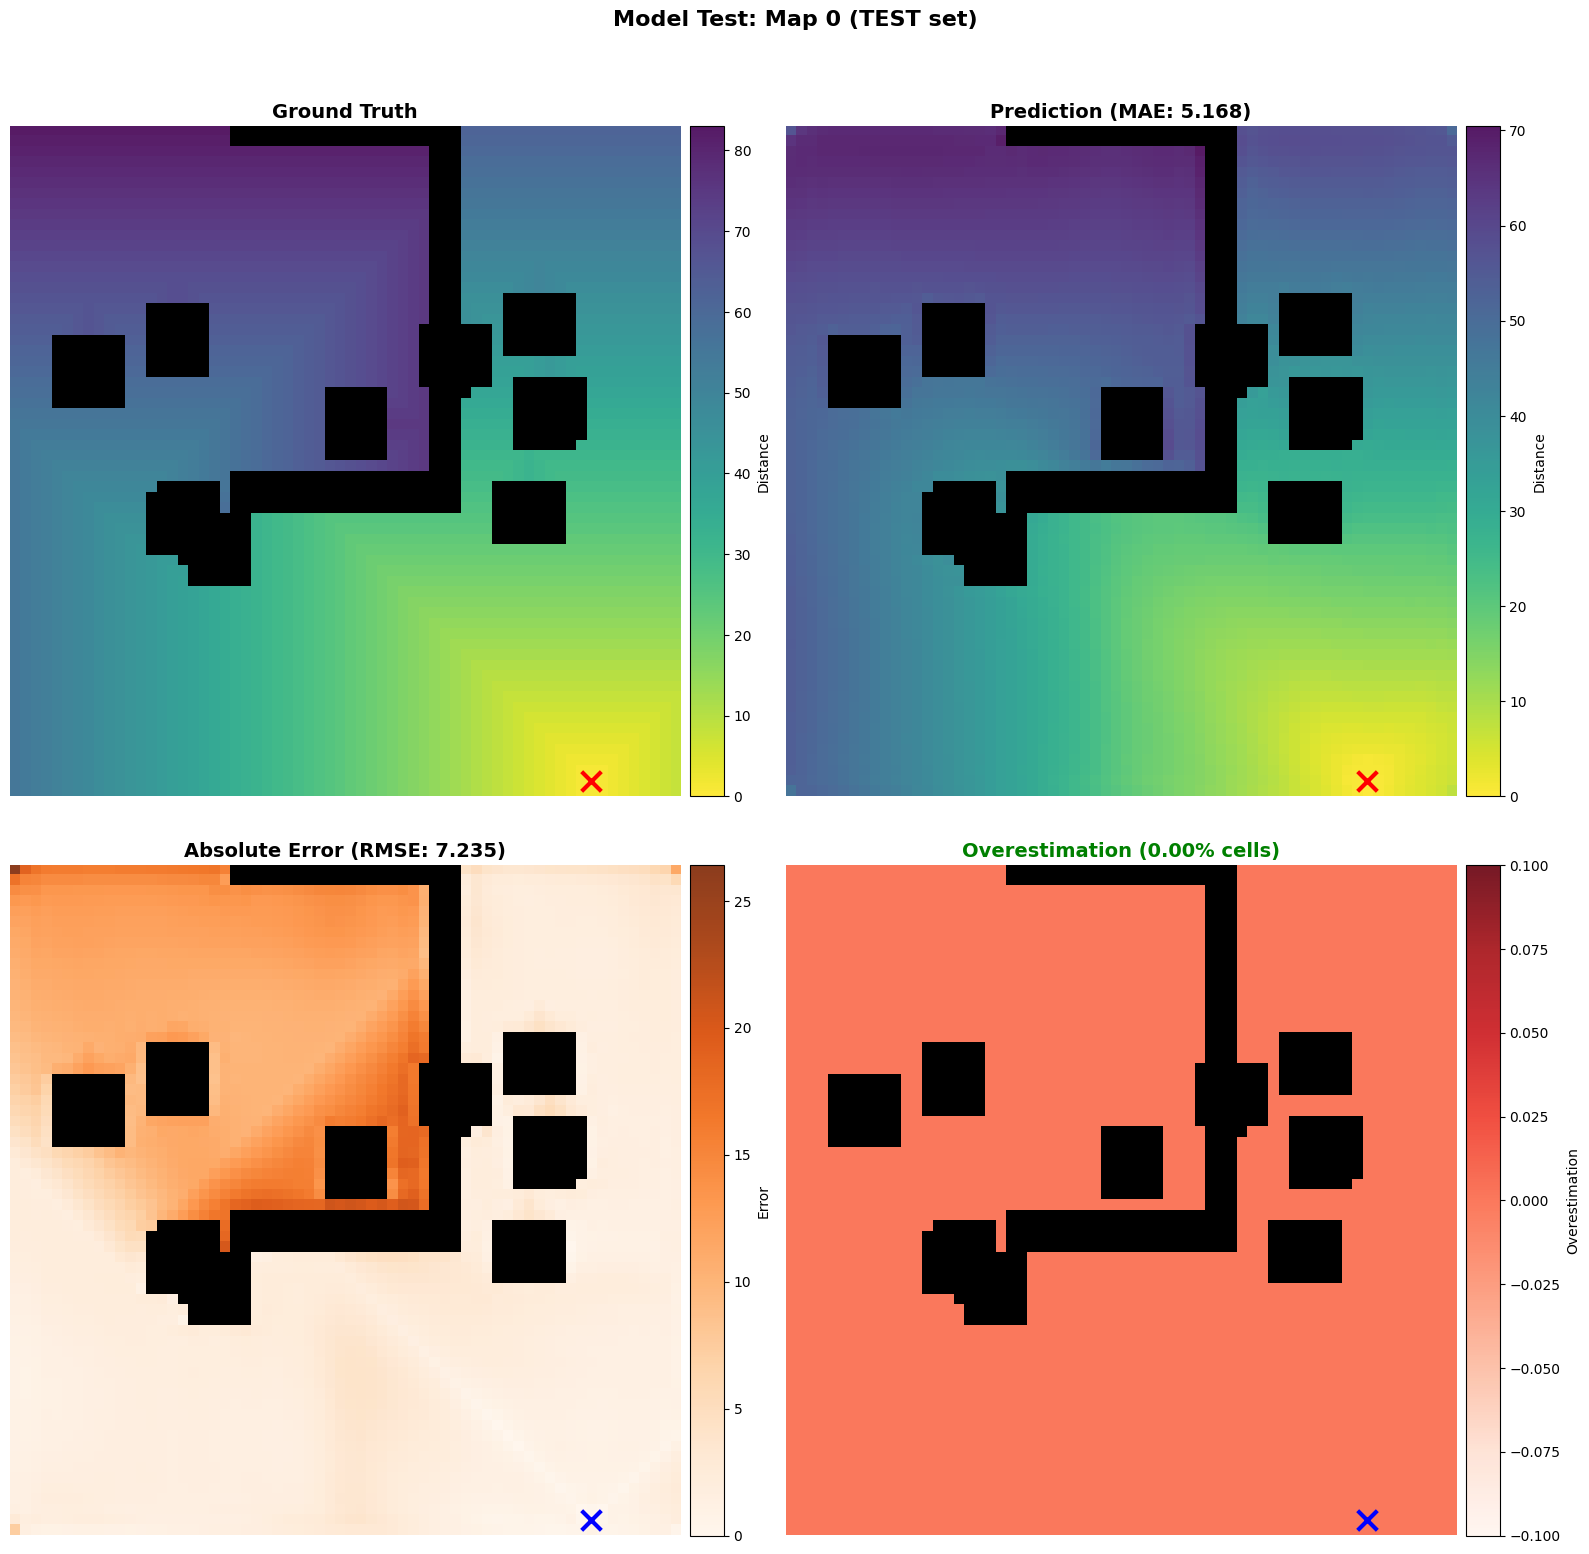

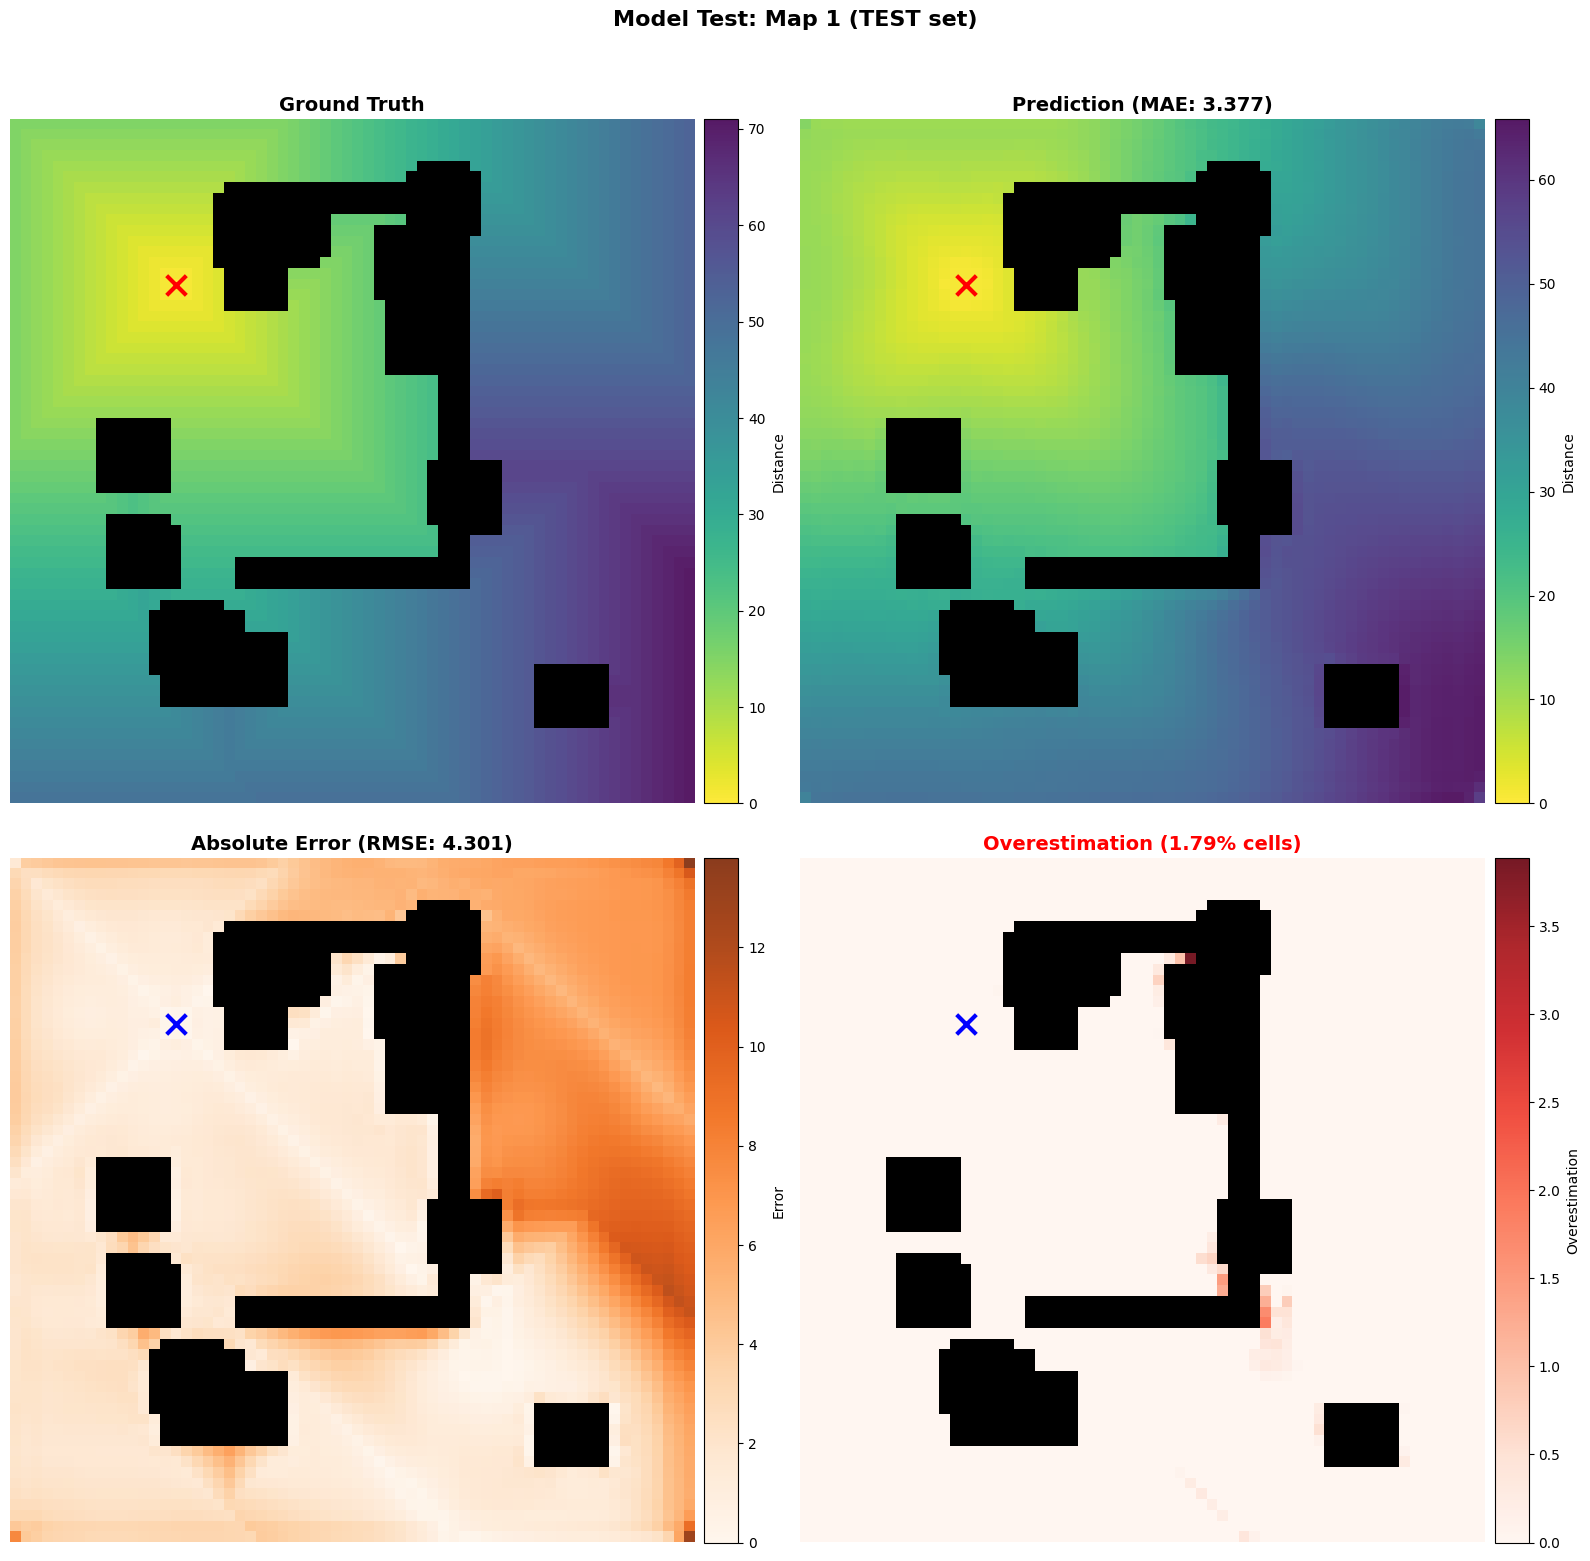

In [ ]:
"""
Test Trained Heuristic Model
Load a trained model and visualize predictions on a specific map from the dataset.
"""

import argparse
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from dataset import PathPlanningDataset
#from learned_heuristic_encoder import HeuristicCNN


def test_model(model_path, data_path, map_index=0, split='test', save_path='model_test_result.png'):
    """
    Test trained model on a specific map and visualize results.

    Args:
        model_path: Path to trained model checkpoint (.pth file)
        data_path: Path to NPZ dataset
        map_index: Index of map to test on
        split: Dataset split ('train', 'valid', or 'test')
        save_path: Where to save visualization
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset
    try:
        dataset = PathPlanningDataset(data_path, split=split)
    except FileNotFoundError:
        print(f"Error: Dataset not found at {data_path}")
        return
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    if map_index >= len(dataset):
        print(f"Error: Index {map_index} out of range (dataset has {len(dataset)} samples)")
        return

    obstacle_map, goal_map, target_distances = dataset[map_index]

    # Prep tensors for model
    obstacle_map_t = torch.from_numpy(obstacle_map).unsqueeze(0).to(device)
    goal_map_t = torch.from_numpy(goal_map).unsqueeze(0).to(device)
    target_distances_t = torch.from_numpy(target_distances).unsqueeze(0).to(device)

    # Load model
    model = HeuristicCNN(in_channels=2, base_channels=64).to(device)

    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
    except FileNotFoundError:
        print(f"Error: Model not found at {model_path}")
        return
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Run inference
    with torch.no_grad():
        pred_distances_t = model(obstacle_map_t, goal_map_t)

    # Convert to numpy for visualization
    obstacle_map_np = obstacle_map[0]
    goal_map_np = goal_map[0]
    target_distances_np = target_distances[0]
    pred_distances_np = pred_distances_t.squeeze(0).squeeze(0).cpu().numpy()

    # Compute metrics on passable cells only
    obstacle_mask = (obstacle_map_np > 0)
    total_passable_cells = np.sum(obstacle_mask)

    # General error metrics
    abs_error = np.abs(pred_distances_np - target_distances_np)
    valid_errors = abs_error[obstacle_mask]
    mae = np.mean(valid_errors)
    rmse = np.sqrt(np.mean(valid_errors ** 2))

    # Overestimation (inadmissibility) metrics
    overestimation_error = np.maximum(0, pred_distances_np - target_distances_np)
    overestimation_on_passable = overestimation_error[obstacle_mask]
    num_inadmissible_cells = np.sum(overestimation_on_passable > 1e-5)
    inadmissible_ratio = num_inadmissible_cells / total_passable_cells if total_passable_cells > 0 else 0
    max_overestimation = np.max(overestimation_on_passable) if num_inadmissible_cells > 0 else 0

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))

    # Find goal location
    goal_coords = np.where(goal_map_np == 1)
    goal_y, goal_x = (goal_coords[0][0], goal_coords[1][0]) if len(goal_coords[0]) > 0 else (None, None)

    # Prepare masked arrays for visualization
    target_masked = np.copy(target_distances_np)
    pred_masked = np.copy(pred_distances_np)
    error_masked = np.copy(abs_error)
    overestimation_masked = np.copy(overestimation_error)

    obstacle_vis_mask = (obstacle_map_np == 0)
    target_masked[obstacle_vis_mask] = np.nan
    pred_masked[obstacle_vis_mask] = np.nan
    error_masked[obstacle_vis_mask] = np.nan
    overestimation_masked[obstacle_vis_mask] = np.nan

    # Top-left: Ground Truth
    axes[0, 0].imshow(obstacle_vis_mask, cmap='gray_r', vmin=0, vmax=1)
    im1 = axes[0, 0].imshow(target_masked, cmap='viridis_r', alpha=0.9, interpolation='nearest')
    if goal_x is not None:
        axes[0, 0].scatter(goal_x, goal_y, marker='x', c='red', s=200, linewidths=3, zorder=10)
    axes[0, 0].set_title('Ground Truth', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')
    divider1 = make_axes_locatable(axes[0, 0])
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im1, cax=cax1, label="Distance")

    # Top-right: Model Prediction
    axes[0, 1].imshow(obstacle_vis_mask, cmap='gray_r', vmin=0, vmax=1)
    im2 = axes[0, 1].imshow(pred_masked, cmap='viridis_r', alpha=0.9, interpolation='nearest')
    if goal_x is not None:
        axes[0, 1].scatter(goal_x, goal_y, marker='x', c='red', s=200, linewidths=3, zorder=10)
    axes[0, 1].set_title(f'Prediction (MAE: {mae:.3f})', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')
    divider2 = make_axes_locatable(axes[0, 1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im2, cax=cax2, label="Distance")

    # Bottom-left: Absolute Error (orange)
    axes[1, 0].imshow(obstacle_vis_mask, cmap='gray_r', vmin=0, vmax=1)
    im3 = axes[1, 0].imshow(error_masked, cmap='Oranges', alpha=0.9, interpolation='nearest', vmin=0)
    if goal_x is not None:
        axes[1, 0].scatter(goal_x, goal_y, marker='x', c='blue', s=200, linewidths=3, zorder=10)
    axes[1, 0].set_title(f'Absolute Error (RMSE: {rmse:.3f})', fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')
    divider3 = make_axes_locatable(axes[1, 0])
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im3, cax=cax3, label="Error")

    # Bottom-right: Overestimation (red)
    axes[1, 1].imshow(obstacle_vis_mask, cmap='gray_r', vmin=0, vmax=1)
    im4 = axes[1, 1].imshow(overestimation_masked, cmap='Reds', alpha=0.9, interpolation='nearest', vmin=0)
    if goal_x is not None:
        axes[1, 1].scatter(goal_x, goal_y, marker='x', c='blue', s=200, linewidths=3, zorder=10)

    title_color = 'red' if inadmissible_ratio > 0.01 else 'green'
    axes[1, 1].set_title(f'Overestimation ({inadmissible_ratio*100:.2f}% cells)',
                         fontsize=14, fontweight='bold', color=title_color)
    axes[1, 1].axis('off')
    divider4 = make_axes_locatable(axes[1, 1])
    cax4 = divider4.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im4, cax=cax4, label="Overestimation")

    fig.suptitle(f'Model Test: Map {map_index} ({split.upper()} set)',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {save_path}")


if __name__ == "__main__":
    model_path = 'models/best_heuristic_model.pth'
    data_path = "bugtrap_forest_064_moore_c16.npz"
    map_index = 0
    split = 'test'
    save_path = 'model_test_result1.png'
    save_path2 = 'model_test_result2.png'
    test_model(
        model_path=model_path,
        data_path=data_path,
        map_index=map_index,
        split=split,
        save_path=save_path
    )

    test_model(
        model_path=model_path,
        data_path=data_path,
        map_index=map_index + 1,
        split=split,
        save_path=save_path2
    )